# Demonstration of Basic Neuron Models

In [1]:
import numpy as np
from neural.model.neuron import *
from neural.backend import NumbaCPUBackendMixin, BackendMixin, NumbaCUDABackendMixin
from neural.utils import generate_stimulus
from neural.utils.plot import plot_multiple
from tqdm.auto import tqdm
# from neural.solver import NumbaEulerSolver
from neural.solver.rk import *
import cupy as cp
from numba import cuda

Define input stimulus.

In [2]:
dt  = 1e-5
dur = 0.2

waveform = generate_stimulus('step', dt, dur-dt/2, (0.05, 0.15), 20.)
t = np.arange(0, len(waveform)*dt-dt/2, dt)

## Base Backend

In [3]:
model_list = [IAF, LeakyIAF, HodgkinHuxley, Wilson, Rinzel, ConnorStevens]
record_base = {key:np.zeros(len(waveform)) for key in model_list}

for M in model_list:
    model = M(backend=BackendMixin)
    for i, wav in tqdm(enumerate(waveform), total=len(waveform), dynamic_ncols=True):
        model.update(dt, stimulus=wav)
        record_base[M][i] = model.v

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

## Numba CPU Backend

In [4]:
model_list = [IAF, LeakyIAF, HodgkinHuxley, Wilson, Rinzel, ConnorStevens]
record_cpu = {key:np.zeros(len(waveform)) for key in model_list}

for M in model_list:
    model = M(backend=NumbaCPUBackendMixin)
    for i, wav in tqdm(enumerate(waveform[:,None]), total=len(waveform), dynamic_ncols=True):
        model.update(dt, stimulus=wav)
        record_cpu[M][i] = model.v

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

## Numba GPU Backend

In [6]:
model_list = [IAF, LeakyIAF, HodgkinHuxley, Wilson, Rinzel, ConnorStevens]
record_cuda = {key:np.zeros(len(waveform)) for key in model_list}

for M in model_list:
    model = M(backend=NumbaCUDABackendMixin)
    for i, wav in tqdm(enumerate(waveform), total=len(waveform), dynamic_ncols=True):
        model.ode(stimulus=wav)
        # record_cuda[M][i] = model.v

/home/tingkai/Projects/NEURAL/numba/numba/cuda/dispatcher.py:463: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (40) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


  0%|                                                                                                         …

LoweringError: Failed in cuda mode pipeline (step: native lowering)
[1m[1mNo definition for lowering <built-in method imp of _dynfunc._Closure object at 0x7f6f403124c0>(float64, int64) -> float64
[1m
File "../../../../../../tmp/neural-compiler-cache-uid1000/7f45061487ff75c9146804ee3bc2f98e.py", line 23:[0m
[1mdef ode(self, stimulus=0.0):
    <source elided>
    for _i in range(numba.cuda.grid(1), self.shape[0], numba.cuda.gridsize(1)):
[1m        stimulus_i = slice_or_return(stimulus, _i)
[0m        [1m^[0m[0m
[0m
[0m[1mDuring: lowering "stimulus_i = call $40load_global.2(stimulus, _i, func=$40load_global.2, args=[Var(stimulus, 7f45061487ff75c9146804ee3bc2f98e.py:22), Var(_i, 7f45061487ff75c9146804ee3bc2f98e.py:22)], kws=(), vararg=None, target=None)" at /tmp/neural-compiler-cache-uid1000/7f45061487ff75c9146804ee3bc2f98e.py (23)[0m

In [7]:
import inspect
print(inspect.getsource(model.ode.dispatcher.py_func))

@numba.cuda.jit
def ode(self, stimulus=0.0):

    for _i in range(numba.cuda.grid(1), self.shape[0], numba.cuda.gridsize(1)):
        stimulus_i = slice_or_return(stimulus, _i)
        self[_i].spike = 0.0
        self[_i].d_v = 1.0 / self[_i].c * (stimulus_i + self[_i].bias)



Plot simulation result.

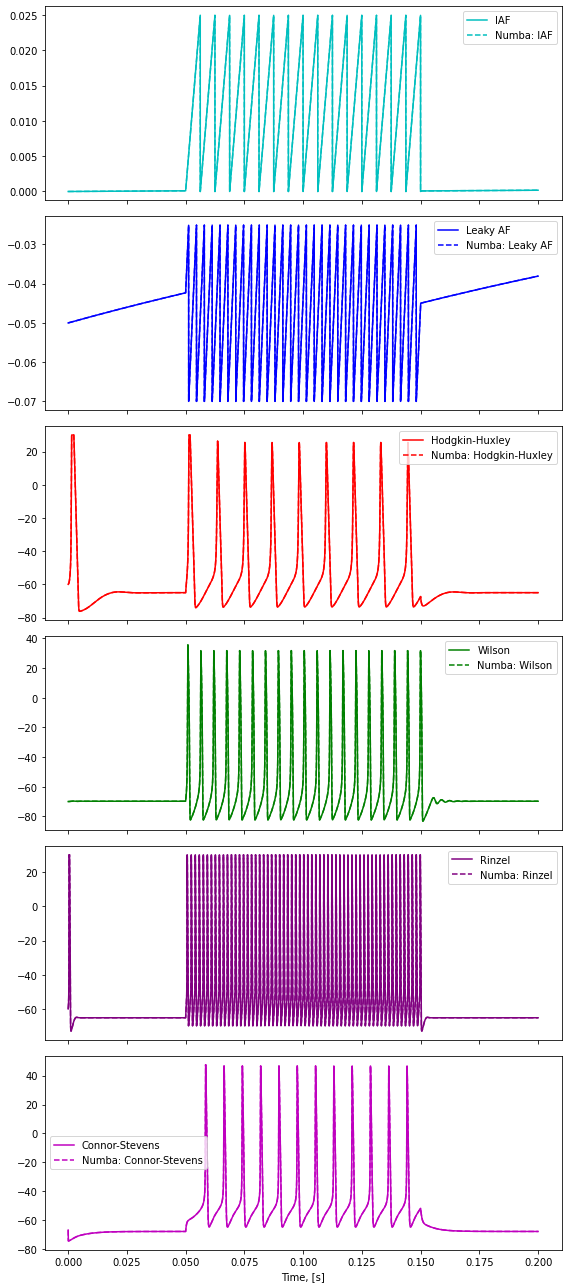

In [8]:
fig, axes = plot_multiple(
    t,
    (record_base[IAF], {'color':'c', 'label':'IAF'}),
    (record_base[LeakyIAF], {'color':'b', 'label':'Leaky AF'}),
    (record_base[HodgkinHuxley], {'color':'r', 'label':'Hodgkin-Huxley'}),
    (record_base[Wilson], {'color':'g', 'label':'Wilson'}),
    (record_base[Rinzel], {'color':'purple', 'label':'Rinzel'}),
    (record_base[ConnorStevens], {'color':'m', 'label':'Connor-Stevens'}),
    figw=8, figh=3, sharex=True
)

_, _ = plot_multiple(
    t,
    (record_cpu[IAF], {'color':'c', 'linestyle':'--', 'label':'Numba: IAF'}),
    (record_cpu[LeakyIAF], {'color':'b', 'linestyle':'--', 'label':'Numba: Leaky AF'}),
    (record_cpu[HodgkinHuxley], {'color':'r', 'linestyle':'--', 'label':'Numba: Hodgkin-Huxley'}),
    (record_cpu[Wilson], {'color':'g', 'linestyle':'--', 'label':'Numba: Wilson'}),
    (record_cpu[Rinzel], {'color':'purple', 'linestyle':'--', 'label':'Numba: Rinzel'}),
    (record_cpu[ConnorStevens], {'color':'m', 'linestyle':'--', 'label':'Numba: Connor-Stevens'}),
    figw=8, figh=3, axes=axes, sharex=True
)

# _, _ = plot_multiple(
#     t,
#     (record_cpu[IAF], {'color':'c', 'linestyle':':', 'label':'Numba: IAF'}),
#     (record_cpu[LeakyIAF], {'color':'b', 'linestyle':':', 'label':'Numba: Leaky AF'}),
#     (record_cpu[HodgkinHuxley], {'color':'r', 'linestyle':':', 'label':'Numba: Hodgkin-Huxley'}),
#     (record_cpu[Wilson], {'color':'g', 'linestyle':':', 'label':'Numba: Wilson'}),
#     (record_cpu[Rinzel], {'color':'purple', 'linestyle':':', 'label':'Numba: Rinzel'}),
#     (record_cpu[ConnorStevens], {'color':'m', 'linestyle':':', 'label':'Numba: Connor-Stevens'}),
#     figw=8, figh=3, axes=axes, sharex=True
# )